In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
from data import fMRIData, fMRIDataEval, LUNA, LUNAEval
from operators import MRI, Operator, CT
from torch import nn
from torch.utils.data import DataLoader
from networks import ResNet, ConvNet, ConvenientModel, TV
import torch
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
from utils import Norm, mkdir
import json
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

In [2]:
# Saves
BASE_PATH = '/store/CCIMI/sl767/Experiments/'

In [3]:
# EXPERIMENT = 'CT_LUNA_Sobolev_-1_Exp_4_PS_1'
# EXPERIMENT = 'CT_LUNA_Sobolev_-1_Exp_5_PS_15'
# EXPERIMENT = 'CT_LUNA_Sobolev_0_Exp_3'
# EXPERIMENT = 'CT_HIGH_NOISE_LUNA_Sobolev_0'
# EXPERIMENT = 'CT_fMRI_Sobolev_0'
# EXPERIMENT = 'MRI_LUNA_Sobolev_-1'
EXPERIMENT = 'MRI_LUNA_Sobolev_0'
# EXPERIMENT = 'MRI_fMRIData_Sobolev_0_Exp_5'
# EXPERIMENT = 'MRI_fMRIData_Sobolev_-1_Exp_3_PS_15'
# EXPERIMENT = 'MRI_fMRIData_Sobolev_-1_Exp_3_PS_1'
# EXPERIMENT = 'MRI_fMRIData_Sobolev_-1_Exp_3_PS_3'
# EXPERIMENT = 'TV'
# EXPERIMENT = 'FBP'

### Reading out experiment parameters as default parameters
with open(BASE_PATH + EXPERIMENT + '/param.json', "r") as read_file:
    parameters = json.load(read_file)
for k, v in parameters.items():
    exec (k + '=v')
    print(k, v)
    
### Reading out the optimal application parameters
if os.path.exists(os.path.join(BASE_PATH, EXPERIMENT, 'optimal_application_param.json')):
    with open(os.path.join(BASE_PATH, EXPERIMENT, 'optimal_application_param.json'), "r") as read_file:
        optimal_application_param = json.load(read_file)
        print('### Optimal application parameters ###')
        for k, v in optimal_application_param.items():
            print(k, v)
else:
    optimal_application_param = {}
    print('No optimal parameteres found')

DATASET LUNA
MODALITY MRI
NOISE_LEVEL 0.001
N_ANGLES 60
INITIAL_MINIMIZATION False
LEARNING_RATE 0.0001
APPLY_RESCALING False
DECAY_FACTOR 0.7
DECAY_EVERY_NSTEPS 5000
BATCH_SIZE 16
TRAINING_STEPS 15000
CHANNELS [1, 64, 128, 128]
DOWNSAMPLING [False, True, True]
SOBOLEV 0
PIXEL_SIZE 1
MU 1
N_STEPS 200
STEP_SIZE 0.3
THRESHOLDING False
N_IMAGES_LOGGING 1
TRACKING_FREQ 500
AVERAGE_NOISE_NORM 18.918380737304688
AVERAGE_NOISE_DUAL 18.918380737304688
AVERAGE_IMAGE_NORM 123.48504638671875
AVERAGE_DUAL_NORM 123.48504638671875
LAMBDA 8.736452102661133
### Optimal application parameters ###
LUNA_MRI_0.001_60 {'LAMBDA': 26.09154510498047, 'N_STEPS': 100, 'STEP_SIZE': 0.1, 'QUALITY': 12.279699325561523, 'SSIM': 0.8360744875348447, 'PSNR': 26.413990756867697, 'SSIM_per_sample': {'0': 0.8339044656451845, '1': 0.8182075800654902, '2': 0.8726402101285466, '3': 0.8347012852226731, '4': 0.8673203113878768, '5': 0.836984468877312, '6': 0.844662256946347, '7': 0.8486700935089868, '8': 0.8327247837127878, '

In [5]:
### Parameter overwrite for experimentation

# Data Setup
# DATASET = 'fMRI'
# MODALITY= 'MRI'
# NOISE_LEVEL = 1e-3
# N_ANGLES = 60
# INITIAL_MINIMIZATION = False
# STEP_SIZE = .3

DATASET = 'LUNA'
MODALITY= 'CT'
NOISE_LEVEL = 6e-3
N_ANGLES = 100
# INITIAL_MINIMIZATION = False
# STEP_SIZE = 1

In [6]:
norm = Norm(s = SOBOLEV, c = 1/PIXEL_SIZE)
dual = norm.dual
if MODALITY == 'MRI':
    operator = MRI(n_directions=N_ANGLES)
elif MODALITY == 'CT':
    operator = CT(n_angles=N_ANGLES)
if DATASET == 'fMRI':
    data = DataLoader(fMRIData(), batch_size=BATCH_SIZE, num_workers=4)
    val_data = DataLoader(fMRIDataEval(), batch_size=BATCH_SIZE)
elif DATASET == 'LUNA':
    data = DataLoader(LUNA(), batch_size=BATCH_SIZE, num_workers=4)
    val_data = DataLoader(LUNAEval(), batch_size=BATCH_SIZE)
operator

Number of training samples found 76138
Number of training samples found 14515


CT Operator
Resolution 256
Angles: 100

In [7]:
# Check if we are dealing with TV experiment:
if 'TV' in EXPERIMENT or 'FBP' in EXPERIMENT:
    regulariser = TV('').cuda()
    print('### TV EXPERIMENT ###')
else:
    regulariser = ResNet(channels=CHANNELS, downsamples=DOWNSAMPLING, base_path=BASE_PATH, exp_name=EXPERIMENT).cuda()

Loading optimal savpoint
Model loaded. Step 13518 Performance 12.519033432006836


In [8]:
def get_training_data(gt, initial_minimisation=False):
    y = operator.add_noise(operator.forward_torch(gt), NOISE_LEVEL)
    x_0 = operator.inverse_torch(y)
    # potentially add a solution of variational problem at this point
    if initial_minimisation:
        x_0 = solve_variational_problem(x_0, y, 10, .1, 0, tracking=None)
    return x_0, y
def l2(x):
    return torch.mean(torch.sqrt(torch.sum(x ** 2, dim=(1,2,3))))

In [9]:
print('Original LAMBDA', LAMBDA)
def get_optimal_lambda():
    gt = next(iter(data)).cuda()
    _, y = get_training_data(gt)
    norm_data = torch.mean(dual(operator.adjoint_torch(operator.forward_torch(gt) - y)))
    return norm_data.cpu().item()

LAMBDA = get_optimal_lambda()
print('New LAMBDA', LAMBDA)

Original LAMBDA 8.736452102661133
New LAMBDA 0.1058897078037262


In [10]:
def solve_variational_problem(x_0, y, x_gt, n_steps=N_STEPS, step_size=STEP_SIZE, lam=LAMBDA, thresholding=THRESHOLDING, image_tracking_freq=5, verbose=True, log_images=False):
    '''
    Solves the variational problem starting at x_0, with data term y, n_steps
    descent steps and regularisation paremeter mu.
    '''
    loggings = {}
    
    def add_scalar(name, value, iteration):
        if name not in loggings.keys():
            loggings[name] = {}
        loggings[name][iteration] = value

    def add_image(name, value, iteration):
        if name not in loggings.keys():
            loggings[name] = {}
        if iteration%image_tracking_freq == 0 and log_images:
            loggings[name][iteration] = value
            if verbose:
                plt.figure(figsize=(10,10))
                plt.imshow(value[0,0,...])
                plt.axis('off')
                plt.show()

    best_per = -1
    best_attained_at = -1
    best_recon = None
    x = x_0.detach()
    for k in range(n_steps):
        data_term = operator.forward_torch(x) - y
        add_scalar('Data_Term', l2(data_term).detach().cpu().numpy()/2, k)
        data_grad = operator.adjoint_torch(data_term)
        add_scalar('L2_Data_Gradient', l2(data_grad).detach().cpu().numpy(), k)
        add_scalar('Dual_Norm_Data_Gradient', torch.mean(dual(data_grad)).detach().cpu().numpy(), k)
        quality = (l2(x_gt - x)).mean().detach().cpu().numpy()
        if quality < best_per or best_per == -1:
            best_attained_at = k
            best_per = quality
            best_recon = x.detach().cpu().numpy()
        add_scalar('Quality', quality, k)
        add_image('Reconstruction', x.cpu().numpy(), k)

        # Getting the regulariser gradient
        reg_grad =  regulariser.gradient(x)
        add_scalar('L2_Regulariser_Gradient', l2(reg_grad).detach().cpu().numpy(), k)
        add_scalar('Dual_Norm_Regulariser_Gradient', torch.mean(dual(reg_grad)).detach().cpu().numpy(), k)
        x = x - step_size * (data_grad + lam * reg_grad)
        
        # Apply thresholding
        if thresholding:
            x = torch.clamp(x, 0, 1)
    
    # Log the global optimum seperately
    loggings['Reconstruction_Quality'] = best_per
    loggings['Best_Attained_At'] = best_attained_at
    loggings['Best_Reconstruction'] =  best_recon
    loggings['Ground Truth'] = x_gt.cpu().numpy()
    loggings['FBP'] = x_0.cpu().numpy()
    # compute PSNR and SSIM
    psnr = 0
    psnr_per_sample = {}
    SSIM = 0
    SSIM_per_sample = {}
    gt = x_gt.cpu().numpy()
    for k in range(BATCH_SIZE):
        p = peak_signal_noise_ratio(gt[k,0,...], best_recon[k,0,...], data_range=1)
        psnr_per_sample[k] = p
        psnr += p
        s = structural_similarity(gt[k,0,...], best_recon[k,0,...])
        SSIM_per_sample[k] = s
        SSIM += s
    loggings['PSNR'] = psnr/BATCH_SIZE
    loggings['SSIM'] = SSIM/BATCH_SIZE
    loggings['PSNR_per_sample'] = psnr_per_sample
    loggings['SSIM_per_sample'] = SSIM_per_sample

    return loggings, x

In [11]:
val_gt = next(iter(val_data)).cuda()
val_fbp, val_y = get_training_data(val_gt)
results = {}

In [23]:
N_STEPS = 500
STEP_SIZE = 1
THRESHOLDING = False
verbose = False
log_images = False
# lambdas = [LAMBDA/8, LAMBDA/4, LAMBDA/2, LAMBDA, 2*LAMBDA]
# lambdas = [3**(i-7) for i in range(3)]
# lambdas = [.2, .3, .5, .7]
# lambdas = [0.001]
lambdas = [LAMBDA/5]
for l in lambdas:
    print('Lambda', l)
    logs, _ = solve_variational_problem(val_fbp, val_y, val_gt, step_size=STEP_SIZE, n_steps=N_STEPS, lam=l, verbose=verbose, log_images=log_images)
    results[l] = logs

Lambda 0.007059313853581746


0.1058897078037262 L2 16.603370666503906
0.1058897078037262 SSIM 0.714633358262
0.1058897078037262 PSNR 23.7806382862
0.3176691234111786 L2 17.858823776245117
0.3176691234111786 SSIM 0.678203820647
0.3176691234111786 PSNR 23.1483763578
0.0529448539018631 L2 15.701149940490723
0.0529448539018631 SSIM 0.72629169368
0.0529448539018631 PSNR 24.2625796251
0.03529656926790873 L2 15.44308090209961
0.03529656926790873 SSIM 0.718529344114
0.03529656926790873 PSNR 24.4034301247
0.007059313853581746 L2 16.96595001220703
0.007059313853581746 SSIM 0.634477911943
0.007059313853581746 PSNR 23.5790545911
Quality


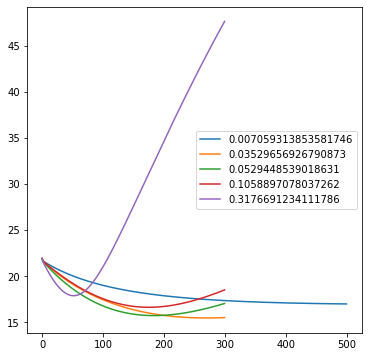

Data_Term


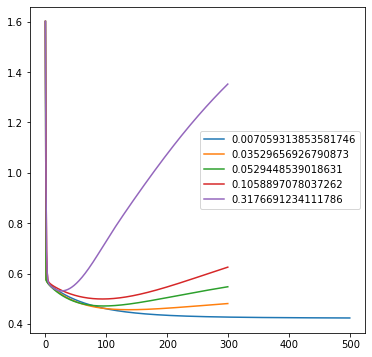

Dual_Norm_Data_Gradient


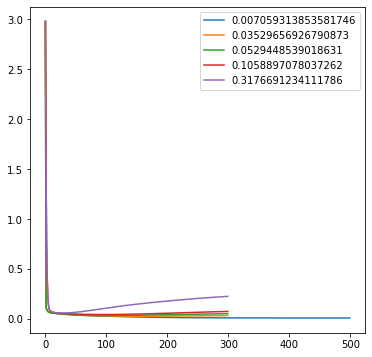

Dual_Norm_Regulariser_Gradient


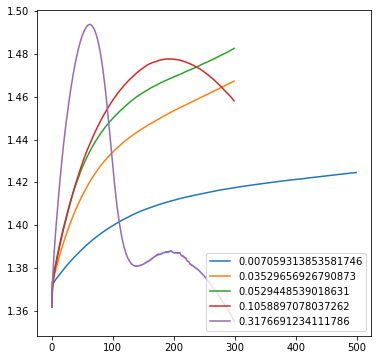

In [25]:
metrics = ['Quality', 'Data_Term', 'Dual_Norm_Data_Gradient', 'Dual_Norm_Regulariser_Gradient']
for l in results.keys():
    print(l, 'L2', results[l]['Reconstruction_Quality'])
    print(l, 'SSIM', results[l]['SSIM'])
    print(l, 'PSNR', results[l]['PSNR'])
for m in metrics:
    print(m)
    plt.figure(figsize=(6,6))
    for l in sorted(list(results.keys())):
#     for l in [LAMBDA/100, 3*LAMBDA/100]:
        plt.plot(results[l][m].keys(), results[l][m].values(), label=l)
    plt.legend()
    plt.show()

In [20]:
# Manually chose optimal hyperparameter
LAMBDA = 0.03529656926790873
print(results[LAMBDA]['Reconstruction_Quality'])

15.44308090209961


In [21]:
# plt.figure(figsize=(10,10))
# plt.imshow((results[LAMBDA]['Reconstruction'])[115][3,0,...])
# plt.axis('off')
# plt.show()

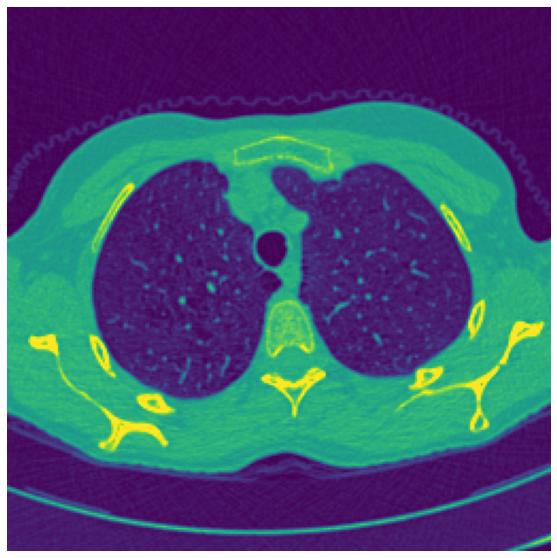

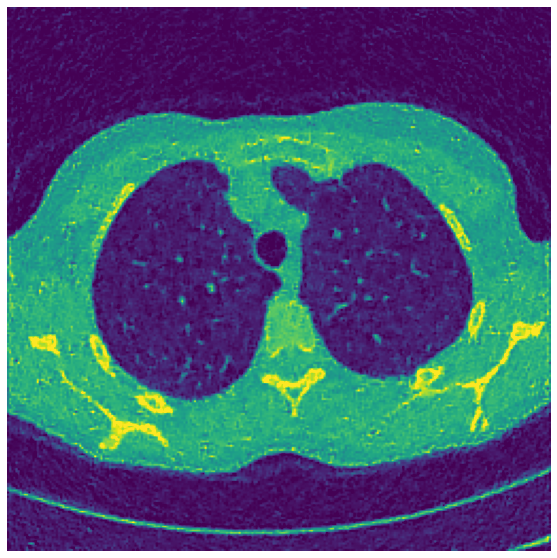

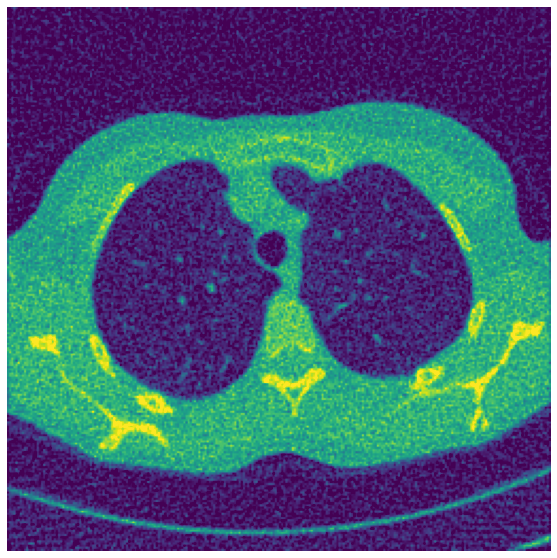

In [22]:
i = 3
plt.figure(figsize=(10,10))
plt.imshow(results[LAMBDA]['Ground Truth'][i,0,...])
plt.axis('off')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(results[LAMBDA]['Best_Reconstruction'][i,0,...], vmin=0, vmax=1)
plt.axis('off')
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(results[LAMBDA]['FBP'][i,0,...], vmin=0, vmax=1)
plt.axis('off')
plt.show()

In [26]:
### Add current experiment to optimal hyperparameters
optimal_application_param[f'{DATASET}_{MODALITY}_{NOISE_LEVEL}_{N_ANGLES}'] = {
    'LAMBDA': LAMBDA,
    'N_STEPS': N_STEPS,
    'STEP_SIZE': STEP_SIZE,
    'STEP_SIZE': STEP_SIZE,
    'QUALITY': results[LAMBDA]['Reconstruction_Quality'].item(),
    'SSIM': results[LAMBDA]['SSIM'],
    'PSNR': results[LAMBDA]['PSNR'],
    'SSIM_per_sample': results[LAMBDA]['SSIM_per_sample'],
    'PSNR_per_sample': results[LAMBDA]['PSNR_per_sample']
}
LAMBDA

0.03529656926790873

In [27]:
# We write the optimal hyperparameters to file
with open(os.path.join(BASE_PATH, EXPERIMENT, 'optimal_application_param.json'),"w") as f:
    json.dump(optimal_application_param, f)
    print('Optimal parameters saved')

Optimal parameters saved


In [28]:
# We write the optimal reconstructions to file as npy and as images
saves_path = os.path.join(BASE_PATH, EXPERIMENT, f'{DATASET}_{MODALITY}_{NOISE_LEVEL}_{N_ANGLES}')
mkdir(saves_path)
# Save numpy arrays
np.save(os.path.join(saves_path, 'GT.npy'), results[LAMBDA]['Ground Truth'])
np.save(os.path.join(saves_path, 'FBP.npy'), results[LAMBDA]['FBP'])
np.save(os.path.join(saves_path, 'Reconstruction.npy'), results[LAMBDA]['Best_Reconstruction'])
# Save individual images
for i in range(BATCH_SIZE):
    for method in ['Ground Truth', 'FBP', 'Best_Reconstruction']:
        plt.figure(figsize=(12,12))
        plt.imshow(results[LAMBDA][method][i,0,...], vmin=0, vmax=1)
        plt.axis('off')
        plt.savefig(os.path.join(saves_path, f'{method}_{i}.png'), transparent=True)
        plt.close()

Created directory /store/CCIMI/sl767/Experiments/MRI_LUNA_Sobolev_0/LUNA_CT_0.006_100


In [29]:
optimal_application_param

{'LUNA_MRI_0.001_60': {'LAMBDA': 26.09154510498047,
  'N_STEPS': 100,
  'STEP_SIZE': 0.1,
  'QUALITY': 12.279699325561523,
  'SSIM': 0.8360744875348447,
  'PSNR': 26.413990756867697,
  'SSIM_per_sample': {'0': 0.8339044656451845,
   '1': 0.8182075800654902,
   '2': 0.8726402101285466,
   '3': 0.8347012852226731,
   '4': 0.8673203113878768,
   '5': 0.836984468877312,
   '6': 0.844662256946347,
   '7': 0.8486700935089868,
   '8': 0.8327247837127878,
   '9': 0.88734556444242,
   '10': 0.7644859033242262,
   '11': 0.8288540549704547,
   '12': 0.8238792834108155,
   '13': 0.8446926704997505,
   '14': 0.8049050273641727,
   '15': 0.8332138410504705},
  'PSNR_per_sample': {'0': 26.409046119966884,
   '1': 25.814628288335516,
   '2': 27.088902434370873,
   '3': 26.77152246191497,
   '4': 26.421159727533947,
   '5': 26.83162099962146,
   '6': 26.93341343053359,
   '7': 26.772484830035417,
   '8': 26.40077890045463,
   '9': 28.02763725568637,
   '10': 24.717544202301816,
   '11': 25.377551363941